In [86]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.models import load_model

In [87]:


# Read the CSV file
csv_file = "./archive/labels_level_1.csv"
df = pd.read_csv(csv_file)
num_digits = 5
num_classes = 10 

# Extract the image filenames and labels
img_filenames = df.iloc[:, 0].values
labels = df.iloc[:, 1].values

#path to the images 
img_folder = "./archive/level_1"

# Preprocess the images
#set height and width
img_height, img_width = 60, 150
images = []

# puts all reshaped and normalized images into list of images
for filename in img_filenames:
    img_path = os.path.join(img_folder, filename)
    img = Image.open(img_path).convert('L')  # Read the image in grayscale
    img = img.resize((img_width, img_height))  # Resize the image
    img = np.array(img) / 255.0  # Normalize pixel values
    img = img.reshape(img_height, img_width, 1)  # Add a channel dimension
    images.append(img)

#all images are converted into numpy array
images = np.array(images)

#function to encode labels
def one_hot_encode(labels, num_digits, num_classes):
    encoded_labels = np.zeros((len(labels), num_digits, num_classes))
    for i, label in enumerate(labels):
        label_str = str(label).zfill(num_digits)  # Convert the label to a string and pad with zeros if necessary
        for j, digit in enumerate(label_str):
            encoded_labels[i, j, int(digit)] = 1
    return encoded_labels

# One-hot encode the labels
labels = one_hot_encode(labels, num_digits, num_classes)

#splits dataset into training, validation and test sets
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)




Actual number: 23023


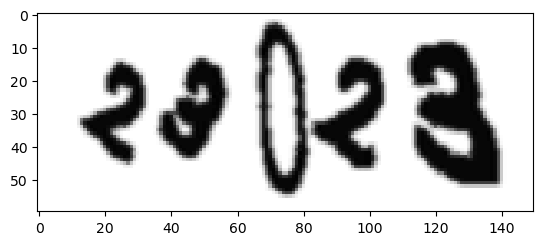

In [88]:
# code to make sure the new dataset contains correct image and label
digit_indices = np.argmax(y_train[2], axis=1)
actual_number = ''.join(str(digit) for digit in digit_indices)

print("Actual number:", actual_number)

# Assuming x_train[0] has shape (height, width, 1)
image = x_train[2].reshape(x_train[2].shape[0], x_train[2].shape[1])

plt.imshow(image, cmap='gray')
plt.show()


In [89]:
# the cnn architecture 
num_digits = 5
num_classes = 10  # There are 10 possible outcomes (0-9)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_digits * num_classes, activation='softmax'))
model.add(keras.layers.Reshape((num_digits, num_classes)))

lr = 1e-4  # Set the learning rate to a smaller value
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Train the model
model.fit(x_train, y_train, batch_size=64, epochs=35, validation_data=(x_val, y_val), callbacks=[early_stopping])




# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)




Epoch 1/35
  2/110 [..............................] - ETA: 45s - loss: 4.9617 - accuracy: 0.0984 

KeyboardInterrupt: 

In [90]:
def preprocess_image(image_path, img_height, img_width):
    img = Image.open(image_path).convert('L')  # Read the image in grayscale
    img = img.resize((img_width, img_height))  # Resize the image
    img = np.array(img) / 255.0  # Normalize pixel values
    img = img.reshape(1, img_height, img_width, 1)  # Add batch and channel dimensions
    return img



In [91]:
def decode_predictions(predictions):
    decoded_preds = []
    for pred in predictions:
        decoded_pred = ''.join([str(np.argmax(digit)) for digit in pred])
        decoded_preds.append(decoded_pred)
    return decoded_preds


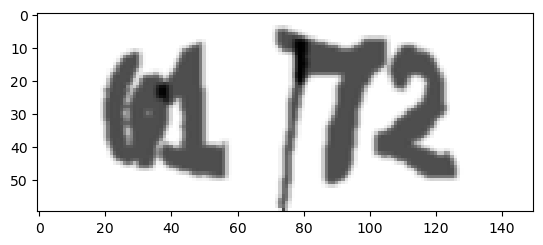

1/1 [==============================] - 0s 107ms/step
Actual CAPTCHA: 61172
Predicted CAPTCHA: 23651


In [92]:
# Preprocess the new CAPTCHA image
new_image_path = "./archive/level_1/file_121.png"
new_img = preprocess_image(new_image_path, img_height, img_width)
plt.imshow(new_img.squeeze(), cmap='gray')
plt.show()

csv_file = "./archive/labels_level_1.csv"
df = pd.read_csv(csv_file)

# Find the actual CAPTCHA for the given image file
actual_numbers = df.loc[df['file_name'] == os.path.basename(new_image_path), 'label'].values[0]



# Make predictions
predictions = model.predict(new_img)

# Decode the predictions
decoded_predictions = decode_predictions(predictions)
print("Actual CAPTCHA:", actual_numbers)
print("Predicted CAPTCHA:", decoded_predictions[0])


In [93]:
# model.save('model-86L1')


47/47 [==============================] - 4s 73ms/step - loss: 0.4781 - accuracy: 0.8616
Test accuracy: 0.8615999817848206


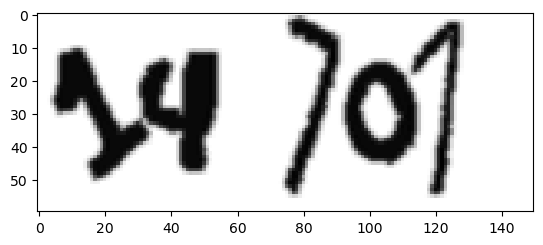

1/1 [==============================] - 0s 110ms/step
Actual CAPTCHA: 14707
Predicted CAPTCHA: 14707


In [94]:

loaded_model = load_model('model-86L1')
test_loss, test_acc = loaded_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

new_image_path = "./archive/level_1/file_1.png"
new_img = preprocess_image(new_image_path, img_height, img_width)
plt.imshow(new_img.squeeze(), cmap='gray')
plt.show()

csv_file = "./archive/labels_level_1.csv"
df = pd.read_csv(csv_file)

# Find the actual CAPTCHA for the given image file
actual_numbers = df.loc[df['file_name'] == os.path.basename(new_image_path), 'label'].values[0]



# Make predictions
predictions = loaded_model.predict(new_img)

# Decode the predictions
decoded_predictions = decode_predictions(predictions)
print("Actual CAPTCHA:", actual_numbers)
print("Predicted CAPTCHA:", decoded_predictions[0])


